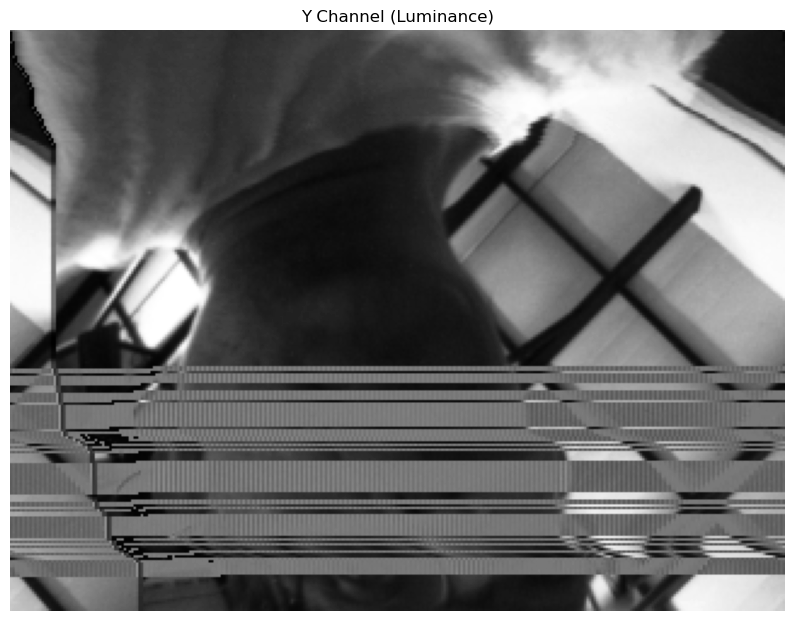

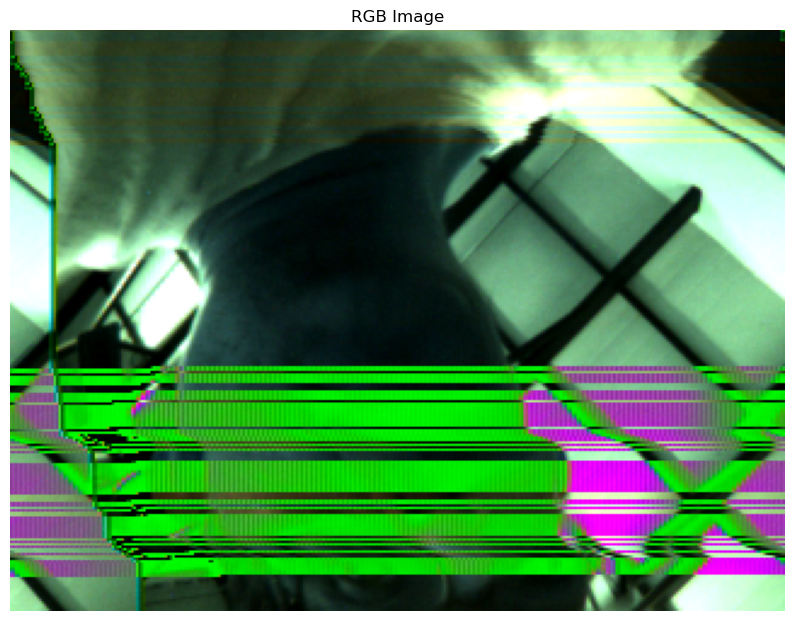

In [130]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def extract_y_channel(yuv_data, width=320, height=240, flip_vertical=False, flip_horizontal=False):
    """
    Extract just the Y channel from YUV422 data.
    
    Args:
        yuv_data: Raw bytes in YUV422 format
        width: Image width
        height: Image height
        flip_vertical: If True, flip the image top to bottom
        flip_horizontal: If True, flip the image left to right
    
    Returns:
        Y channel as numpy array of shape (height, width)
    """
    yuv = np.frombuffer(yuv_data, dtype=np.uint8)
    yuv = yuv.reshape((height, width//2, 4))
    
    # Extract Y components
    y0 = yuv[:, :, 0]  # First Y in each group
    y1 = yuv[:, :, 2]  # Second Y in each group
    
    # Combine Y values
    y = np.zeros((height, width), dtype=np.uint8)
    y[:, 0::2] = y0
    y[:, 1::2] = y1
    
    # Apply flipping if requested
    if flip_vertical:
        y = np.flipud(y)
    if flip_horizontal:
        y = np.fliplr(y)
    
    return y

def display_y_channel(yuv_data, width=320, height=240, flip_vertical=False, flip_horizontal=False):
    """
    Display just the Y (luminance) channel from YUV422 data
    
    Args:
        yuv_data: Raw bytes in YUV422 format
        width: Image width
        height: Image height
        flip_vertical: If True, flip the image top to bottom
        flip_horizontal: If True, flip the image left to right
    """
    y = extract_y_channel(yuv_data, width, height, flip_vertical, flip_horizontal)
    
    plt.figure(figsize=(10, 8))
    plt.imshow(y, cmap='gray')
    plt.axis('off')
    plt.title('Y Channel (Luminance)')
    plt.show()
    
    return y

def yuv422_to_rgb(yuv_data, width=320, height=240, flip_vertical=False, flip_horizontal=False):
    """
    Convert YUV422 (YUYV) format to RGB with optional flipping.
    YUV422 format: [Y0 U0 Y1 V0] [Y2 U1 Y3 V1] ...
    Each pixel pair shares U and V values.
    
    Args:
        yuv_data: Raw bytes in YUV422 format
        width: Image width
        height: Image height
        flip_vertical: If True, flip the image top to bottom
        flip_horizontal: If True, flip the image left to right
    
    Returns:
        RGB numpy array of shape (height, width, 3)
    """
    # Reshape data to group YUYV bytes together
    yuv = np.frombuffer(yuv_data, dtype=np.uint8)
    yuv = yuv.reshape((height, width//2, 4))
    
    # Extract Y, U, V components
    y0 = yuv[:, :, 0].astype(np.float32)  # First Y in each group
    u = yuv[:, :, 1].astype(np.float32)   # U for both pixels
    y1 = yuv[:, :, 2].astype(np.float32)  # Second Y in each group
    v = yuv[:, :, 3].astype(np.float32)   # V for both pixels
    
    # Duplicate U and V for each Y (since they're shared between pixel pairs)
    y = np.zeros((height, width), dtype=np.float32)
    y[:, 0::2] = y0
    y[:, 1::2] = y1
    
    u = np.repeat(u, 2, axis=1)
    v = np.repeat(v, 2, axis=1)
    
    # Apply flipping to YUV components if requested
    if flip_vertical:
        y = np.flipud(y)
        u = np.flipud(u)
        v = np.flipud(v)
    
    if flip_horizontal:
        y = np.fliplr(y)
        u = np.fliplr(u)
        v = np.fliplr(v)
    
    # Convert to floating point and center at 0
    y = (y - 16) * 1.164  # Adjust brightness range
    u = u - 128
    v = v - 128
    
    # BT.601 YUV to RGB conversion matrix coefficients
    kr = 0.299
    kg = 0.587
    kb = 0.114
    
    r = y + (2 - 2 * kr) * v
    g = y - kb * (2 - 2 * kb) * u / kg - kr * (2 - 2 * kr) * v / kg
    b = y + (2 - 2 * kb) * u
    
    # Alternative coefficients if the above don't work well:
    # r = y + 1.403 * v
    # g = y - 0.344 * u - 0.714 * v
    # b = y + 1.773 * u
    
    # Clip values to valid range
    r = np.clip(r, 0, 255)
    g = np.clip(g, 0, 255)
    b = np.clip(b, 0, 255)
    
    
    # Stack RGB channels and convert to uint8
    rgb = np.stack([r, g, b], axis=2).astype(np.uint8)
    
    return rgb

def display_yuv422(yuv_data, width=320, height=240, flip_vertical=False, flip_horizontal=False):
    """
    Convert YUV422 data to RGB and display using matplotlib
    
    Args:
        yuv_data: Raw bytes in YUV422 format
        width: Image width
        height: Image height
        flip_vertical: If True, flip the image top to bottom
        flip_horizontal: If True, flip the image left to right
    """
    rgb = yuv422_to_rgb(yuv_data, width, height, flip_vertical, flip_horizontal)
    plt.figure(figsize=(10, 8))
    plt.imshow(rgb)
    plt.axis('off')
    plt.title('RGB Image')
    plt.show()
    
    return rgb

def load_yuv422(filename, width, height):
    """ Load raw YUV422 file (2 bytes per pixel) and return as numpy array """
    with open(filename, 'rb') as f:
        yuv_data = np.frombuffer(f.read(), dtype=np.uint8)

    # Ensure data size matches expected resolution
    expected_size = width * height * 2
    assert len(yuv_data) == expected_size, f"Invalid file size: Expected {expected_size}, got {len(yuv_data)}"

    return yuv_data
# Read file
yuv_data = load_yuv422("output.raw", 320, 240)

# Display Y channel
y_channel = display_y_channel(yuv_data)

# Display full RGB image for comparison
rgb_image = display_yuv422(yuv_data)

In [108]:
0x13,0x01, 0x02, 0x7a

(19, 1, 2, 122)